In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


df8 = pd.read_csv('./data/PEMS08/PEMS08.csv')

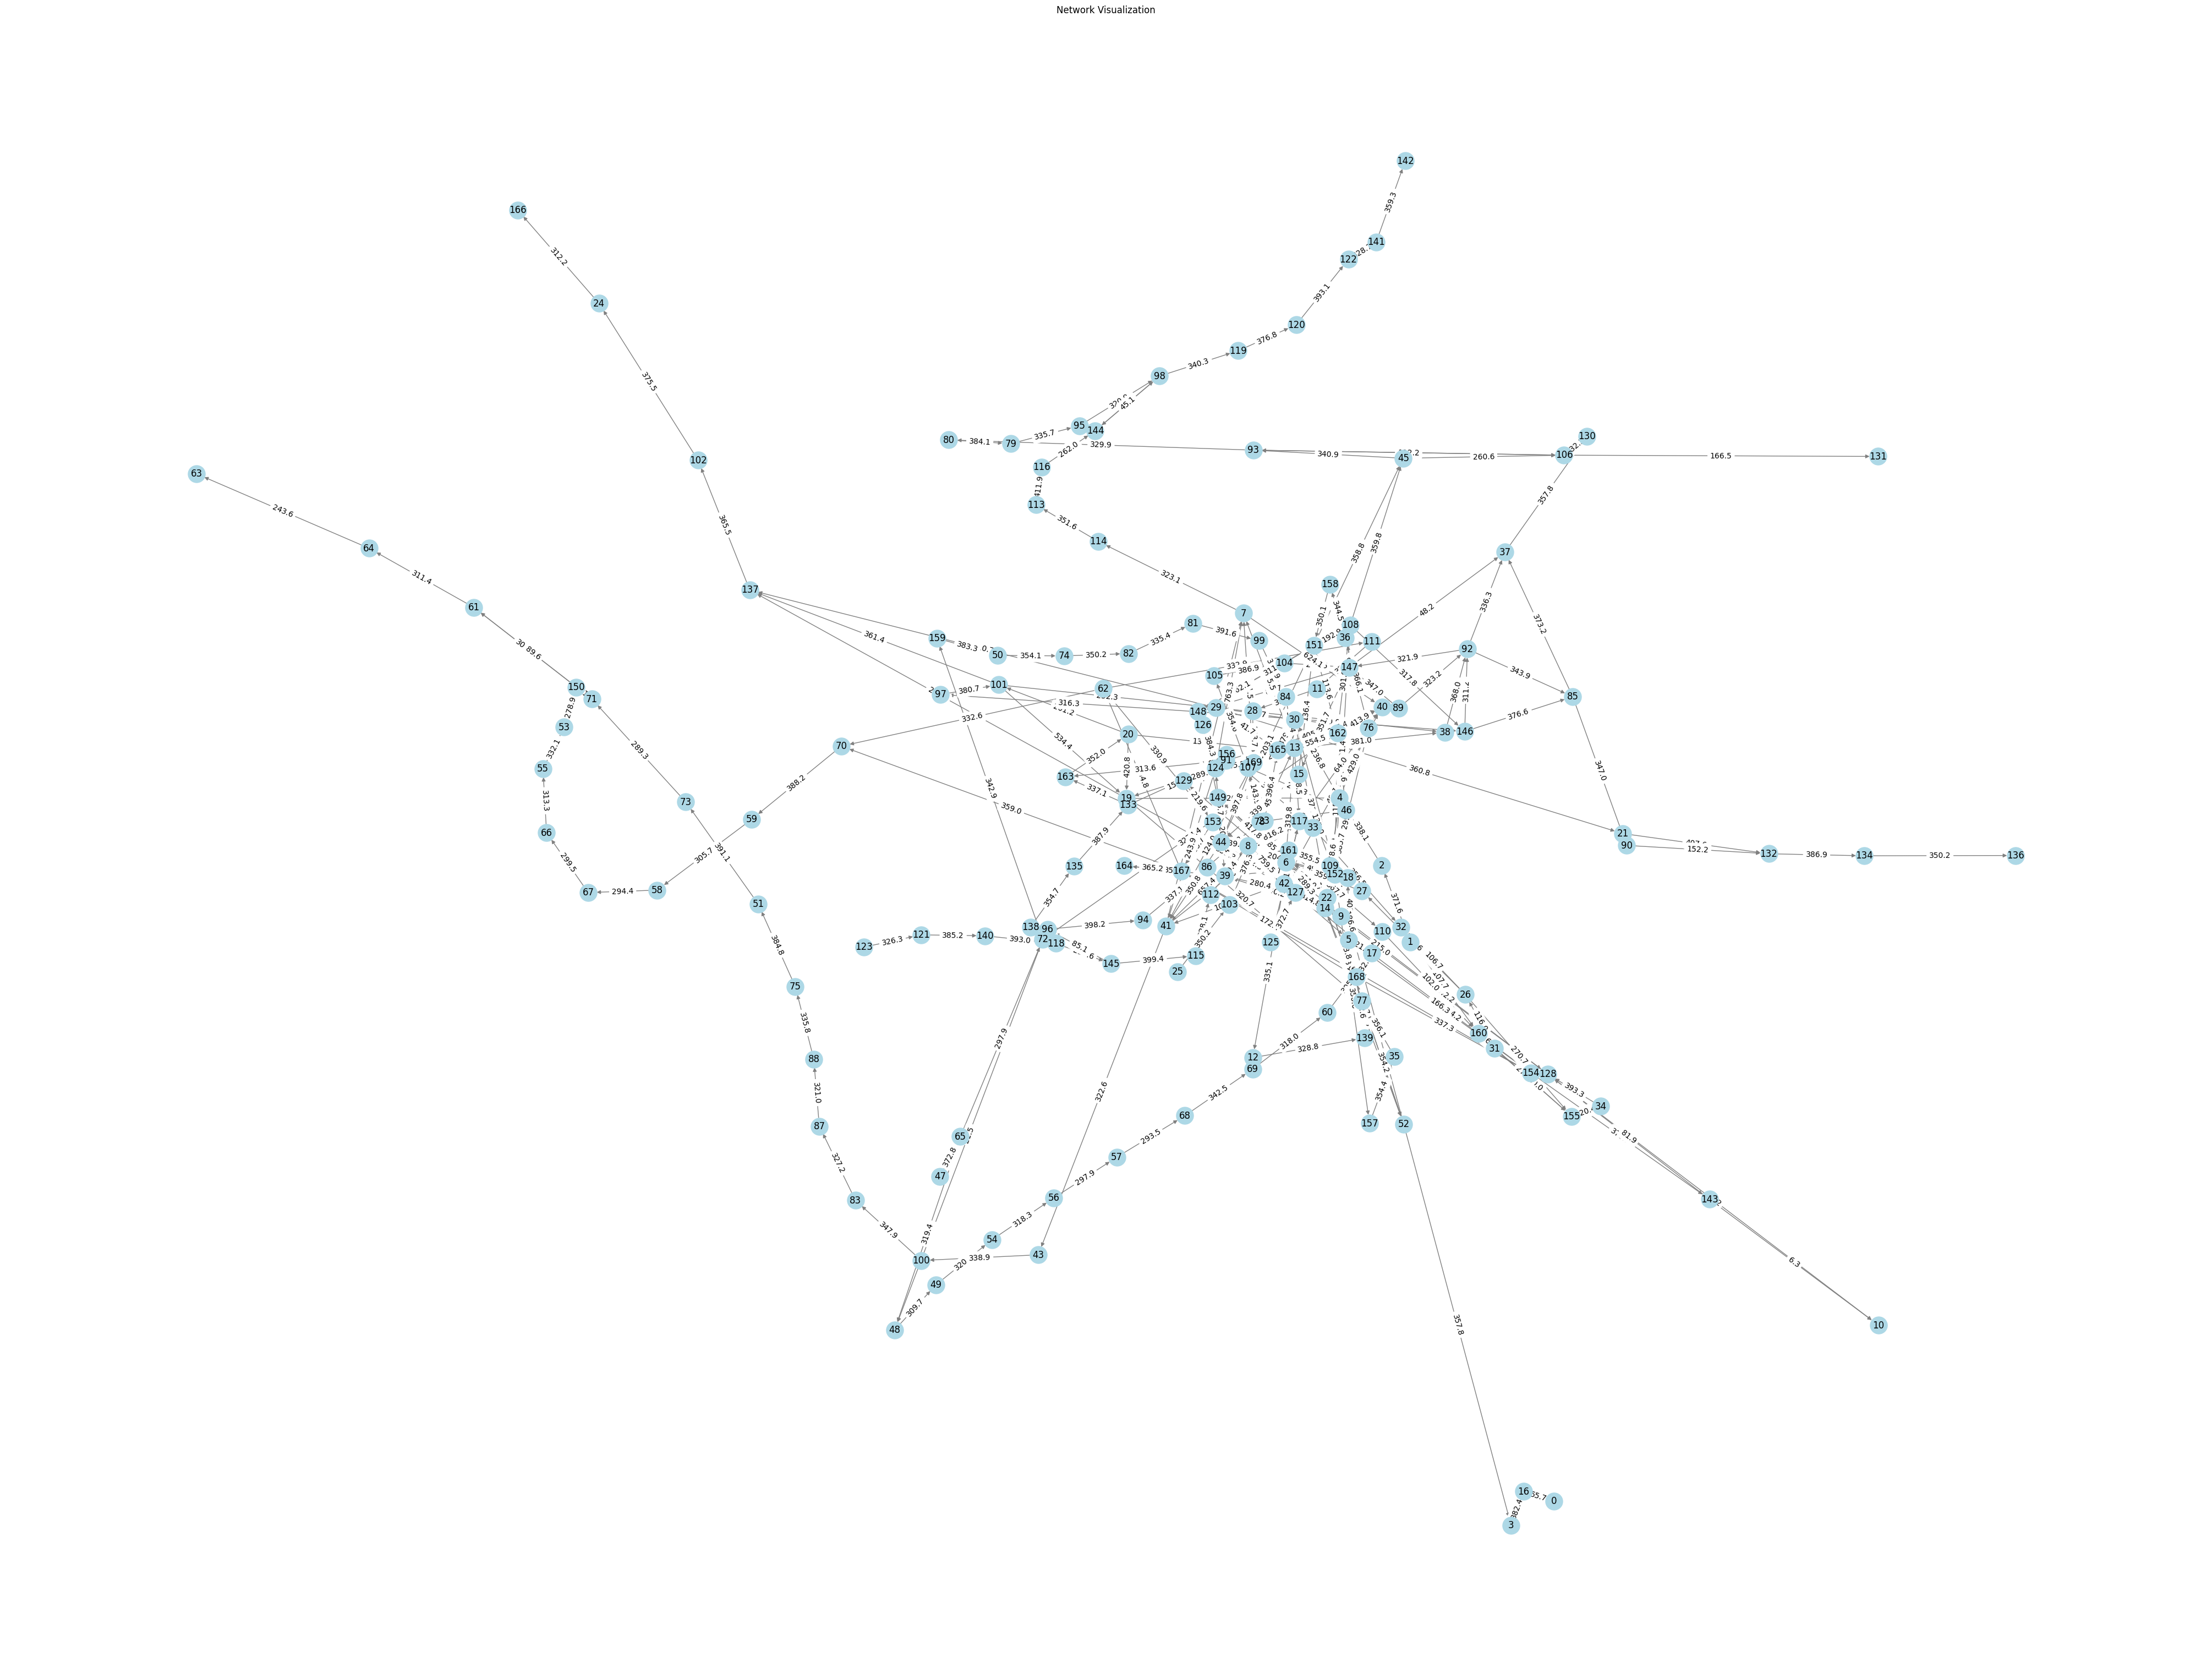

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

G = nx.from_pandas_edgelist(df8, 'from', 'to', ['cost'], create_using=nx.DiGraph)

pos = nx.spring_layout(G)

plt.figure(figsize=(40, 30))

nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', arrows=True)
labels = nx.get_edge_attributes(G, 'cost')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Network Visualization')
plt.show()



In [12]:

class IsolationTree:
    def __init__(self, height_limit):
        self.height_limit = height_limit
        self.tree = None

    def fit(self, X, current_height=0):
        if len(X) <= 1 or current_height >= self.height_limit:
            return {'size': len(X)}
        
        feature = np.random.randint(0, X.shape[1])
        split_value = np.random.uniform(min(X[:, feature]), max(X[:, feature]))

        left_mask = X[:, feature] < split_value
        right_mask = ~left_mask

        return {
            'feature': feature,
            'split_value': split_value,
            'left': self.fit(X[left_mask], current_height + 1),
            'right': self.fit(X[right_mask], current_height + 1)
        }

    def path_length(self, x, tree=None, current_height=0):
        if tree is None:
            tree = self.tree
        
        if 'size' in tree:
            return current_height + self._c(tree['size'])
        
        feature = tree['feature']
        split_value = tree['split_value']
        
        if x[feature] < split_value:
            return self.path_length(x, tree['left'], current_height + 1)
        else:
            return self.path_length(x, tree['right'], current_height + 1)

    @staticmethod
    def _c(size):
        if size <= 1:
            return 0
        else:
            return 2 * (np.log(size - 1) + 0.5772156649) - (2 * (size - 1) / size)

class IsolationForest:
    def __init__(self, n_trees=100, sample_size=256, height_limit=8):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.height_limit = height_limit
        self.trees = []

    def fit(self, X):
        self.trees = []
        for _ in range(self.n_trees):
            sample_indices = np.random.choice(X.shape[0], self.sample_size, replace=False)
            X_sample = X[sample_indices]
            tree = IsolationTree(self.height_limit)
            tree.tree = tree.fit(X_sample)
            self.trees.append(tree)

    def anomaly_score(self, X):
        scores = np.zeros(X.shape[0])
        for tree in self.trees:
            paths = np.array([tree.path_length(x) for x in X])
            scores += paths
        scores /= len(self.trees)
        return 2 ** (-scores / self._c(self.sample_size))

    @staticmethod
    def _c(size):
        if size <= 1:
            return 0
        else:
            return 2 * (np.log(size - 1) + 0.5772156649) - (2 * (size - 1) / size)

In [13]:

X = df8[['cost']].values

iso_forest = IsolationForest(n_trees=100, sample_size=256, height_limit=8)
iso_forest.fit(X)

scores = iso_forest.anomaly_score(X)

threshold = np.percentile(scores, 98)
df8['Anomaly'] = (scores >= threshold).astype(int)

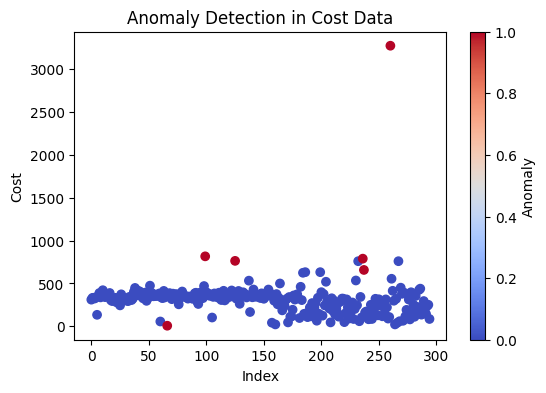

In [14]:
plt.figure(figsize=(6, 4))
plt.scatter(df8.index, df8['cost'], c=df8['Anomaly'], cmap='coolwarm', marker='o')
plt.xlabel('Index')
plt.ylabel('Cost')
plt.title('Anomaly Detection in Cost Data')
plt.colorbar(label='Anomaly')
plt.show()

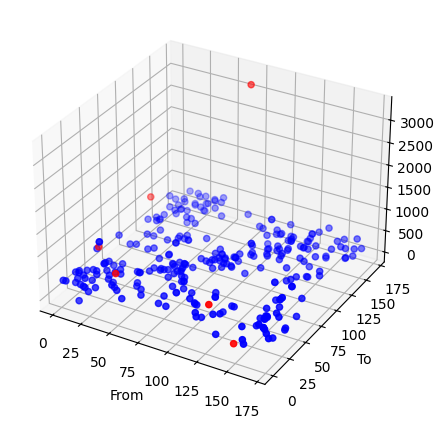

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

colors = df8['Anomaly'].apply(lambda x: 'red' if x == 1 else 'blue')
sc = ax.scatter(df8['from'], df8['to'], df8['cost'], c=colors, marker='o')

ax.set_xlabel('From')
ax.set_ylabel('To')
ax.set_zlabel('Cost', labelpad=20)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

plt.show()

In [16]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(df8[['cost']], df8['Anomaly'])
print(f'Silhouette Score: {silhouette_avg:.2f}')


Silhouette Score: 0.82


In [17]:
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(df8[['cost']], df8['Anomaly'])

print(f'Davies-Bouldin Index: {dbi:.2f}')

Davies-Bouldin Index: 1.11


Anomalies detected (from, to, cost):
(143, 10, 6.3)
(8, 117, 816.2)
(147, 37, 48.2)
(101, 19, 534.4)
(16, 0, 55.7)
(110, 160, 102.0)
(71, 61, 89.6)
(130, 106, 532.3)
(72, 162, 3274.4)
(90, 132, 152.2)
(145, 96, 85.1)


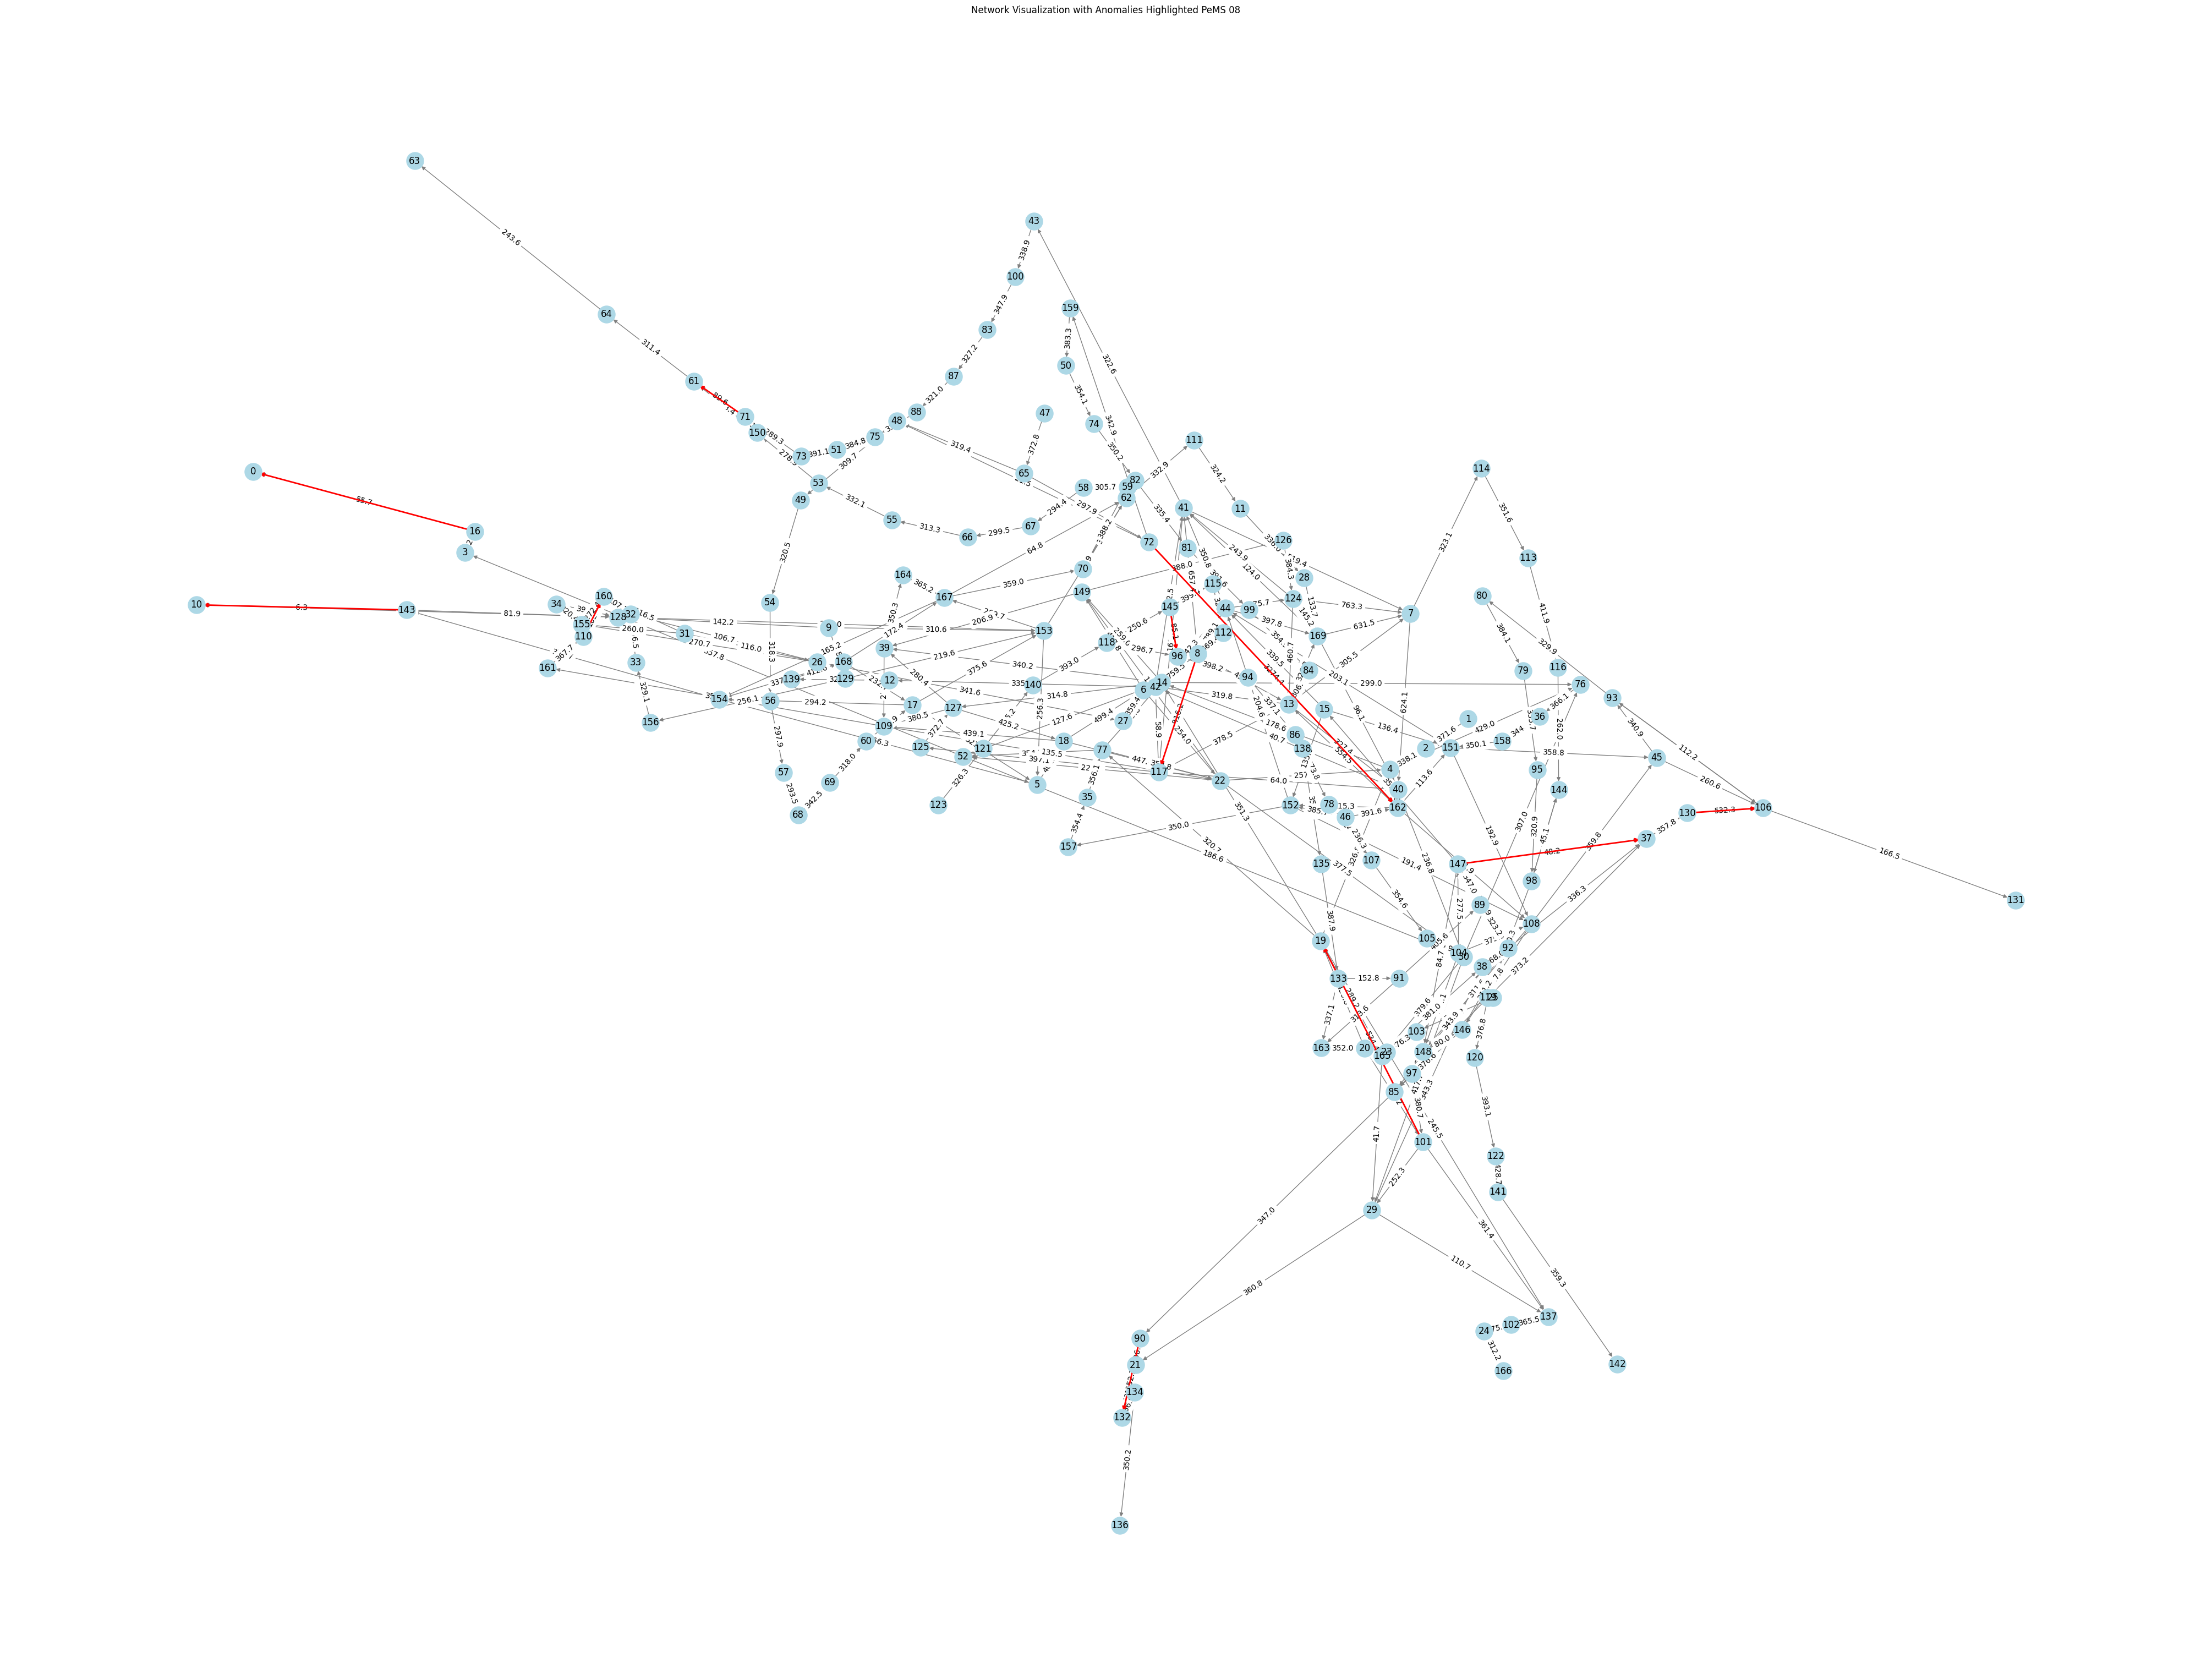

In [18]:

import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

df = pd.read_csv('./data/PEMS08/PEMS08.csv')

G = nx.from_pandas_edgelist(df, 'from', 'to', ['cost'], create_using=nx.DiGraph)

partition = community_louvain.best_partition(G.to_undirected())

for u, v, d in G.edges(data=True):
    d['community'] = partition[u]

anomalies = []
for community in set(partition.values()):
    edges = [(u, v, d['cost']) for u, v, d in G.edges(data=True) if d['community'] == community]
    costs = [cost for _, _, cost in edges]
    
    costs_reshaped = np.array([[cost] for cost in costs])
    
    iforest = IsolationForest(n_trees=100, sample_size=min(256, len(costs_reshaped)), height_limit=8)
    iforest.fit(costs_reshaped)
    scores = iforest.anomaly_score(costs_reshaped)
    
    threshold = np.percentile(scores, 99) 
    for (u, v, cost), score in zip(edges, scores):
        if score > threshold:
            anomalies.append((u, v, cost))

print("Anomalies detected (from, to, cost):")
for anomaly in anomalies:
    print(anomaly)

pos = nx.spring_layout(G)
plt.figure(figsize=(40, 30))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', arrows=True)
labels = nx.get_edge_attributes(G, 'cost')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

anomaly_edges = [(u, v) for u, v, cost in anomalies]
nx.draw_networkx_edges(G, pos, edgelist=anomaly_edges, edge_color='r', width=2)

plt.title('Network Visualization with Anomalies Highlighted PeMS 08')
plt.show()
